## Breast Cancer Prediction

In [1]:
# Loading libraries needed for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from numpy.random import RandomState
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_palette(['#06B1F0', '#FC4B60'])

In [2]:
new_data = pd.read_csv('data/data_updated.csv', index_col=0)
print new_data.shape
new_data.head()

(456, 10)


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


### Class distribution

In [3]:
new_data['Class'].value_counts()

0    444
1     12
Name: Class, dtype: int64

The problem we are trying to solve in this analysis is breast cancer prediction. Based on the features available, we are going to predict whether the tumor a patient has is benign or malignant. One of the biggest challenges of this analysis is to deal with an imbalanced dataset

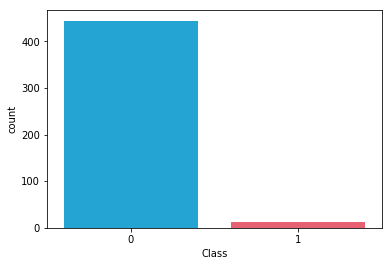

In [4]:
sns.set_palette(['#06B1F0', '#FC4B60'])
sns.countplot(new_data['Class'])

# Experiment setup

Choosing the evaluation metrics is also quite challenging when dealing with imbalanced datasets. Accuracy is not the right metric as the accuracy of baseline model that classifies everything as over-reperesented class is 97%. Any model we build should beat this accuracy score.  

In [5]:
def metrics(true, preds):
    """
    Function to calculate evaluation metrics 
    parameters: true values, predictions
    prints accuracy, recall, precision and f1 scores
    """
    accuracy = accuracy_score(true, preds)
    recall = recall_score(true, preds)
    precision = precision_score(true, preds)
    f1score = f1_score(true, preds)
    print 'accuracy: {}, recall: {}, precision: {}, f1-score: {}'.format(accuracy, recall, precision, f1score)

## Baseline Model - Train and test without additional pre-processing

Using stratified sampling instead of random train test split. This splits the target proportionally between training and test set.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(new_data.drop('Class', axis=1), new_data['Class'], test_size = 0.30, random_state=42, stratify=new_data['Class'])
print ("TRAIN DATA SHAPE: ", x_train.shape)
print ("TEST DATA SHAPE: ", x_test.shape)
rf = RandomForestClassifier(n_estimators=5, random_state=12)
rf.fit(x_train, y_train)

('TRAIN DATA SHAPE: ', (319, 9))
('TEST DATA SHAPE: ', (137, 9))


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

### Applying to held-out set

In [7]:
preds = rf.predict(x_test)
metrics(y_test, preds)

accuracy: 0.970802919708, recall: 0.5, precision: 0.5, f1-score: 0.5


## Over-sampling the minority class in training set using SMOTE

In [8]:
y_train = y_train.reshape(-1)
sm = SMOTE(random_state=42)
X, Y = sm.fit_sample(x_train, y_train)
print 'Shape of oversampled data: {}'.format(X.shape)
print 'Shape of Y: {}'.format(Y.shape)

Shape of oversampled data: (622, 9)
Shape of Y: (622,)


Text(0.5,1,u'Balanced training data')

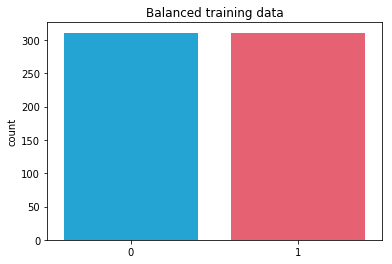

In [9]:
sns.set_palette(['#06B1F0', '#FC4B60'])
sns.countplot(Y)
plt.title('Balanced training data')

In [10]:
rf = RandomForestClassifier(n_estimators=5, random_state=12)
recall_scores = cross_val_score(rf, X, Y, scoring='recall', cv=5)
f1_scores = cross_val_score(rf, X,Y, scoring='f1', cv=5)
accuracy_scores = cross_val_score(rf, X,Y, scoring='accuracy', cv=5)
precision_scores = cross_val_score(rf, X,Y, scoring='precision', cv=5)
print 'Average Recall score: {}'.format(np.mean(recall_scores))
print 'Average F1 scores: {}'.format(np.mean(f1_scores))
print 'Average Accuracy scores: {}'.format(np.mean(accuracy_scores))
print 'Average Precision scores: {}'.format(np.mean(precision_scores))

Average Recall score: 0.996825396825
Average F1 scores: 0.993625396825
Average Accuracy scores: 0.993573988735
Average Precision scores: 0.990575396825


whoohooo. the cross validation scores look amazing. Let's see how it performs on test data

### Results for training set

In [11]:
preds = cross_val_predict(rf, X, Y, cv=5)
print 'Accuracy score: {}'.format(accuracy_score(Y, preds))
print 'Recall score: {}'.format(recall_score(Y, preds))
print 'Precision score: {}'.format(precision_score(Y, preds))
print 'f1-score: {}'.format(f1_score(Y, preds))

Accuracy score: 0.993569131833
Recall score: 0.996784565916
Precision score: 0.990415335463
f1-score: 0.99358974359


### Results for test set

In [12]:
rf = RandomForestClassifier(n_estimators=5, random_state=12)
rf.fit(X, Y)
test_preds = rf.predict(x_test)
print 'Accuracy score: {}'.format(accuracy_score(y_test, test_preds))
print 'Recall score: {}'.format(recall_score(y_test, test_preds))
print 'Precision score: {}'.format(precision_score(y_test, test_preds))
print 'f1-score: {}'.format(f1_score(y_test, test_preds))

Accuracy score: 0.948905109489
Recall score: 0.5
Precision score: 0.285714285714
f1-score: 0.363636363636


What happened? cross-validated score is almost 100% but test recall is only 50%. looks like model is over-fitting. But I did cross-validation to detect if my model was overfitting

Let's look at the distribution of features over 2 classes. 

## Distribution of features over malignant and benign tumors

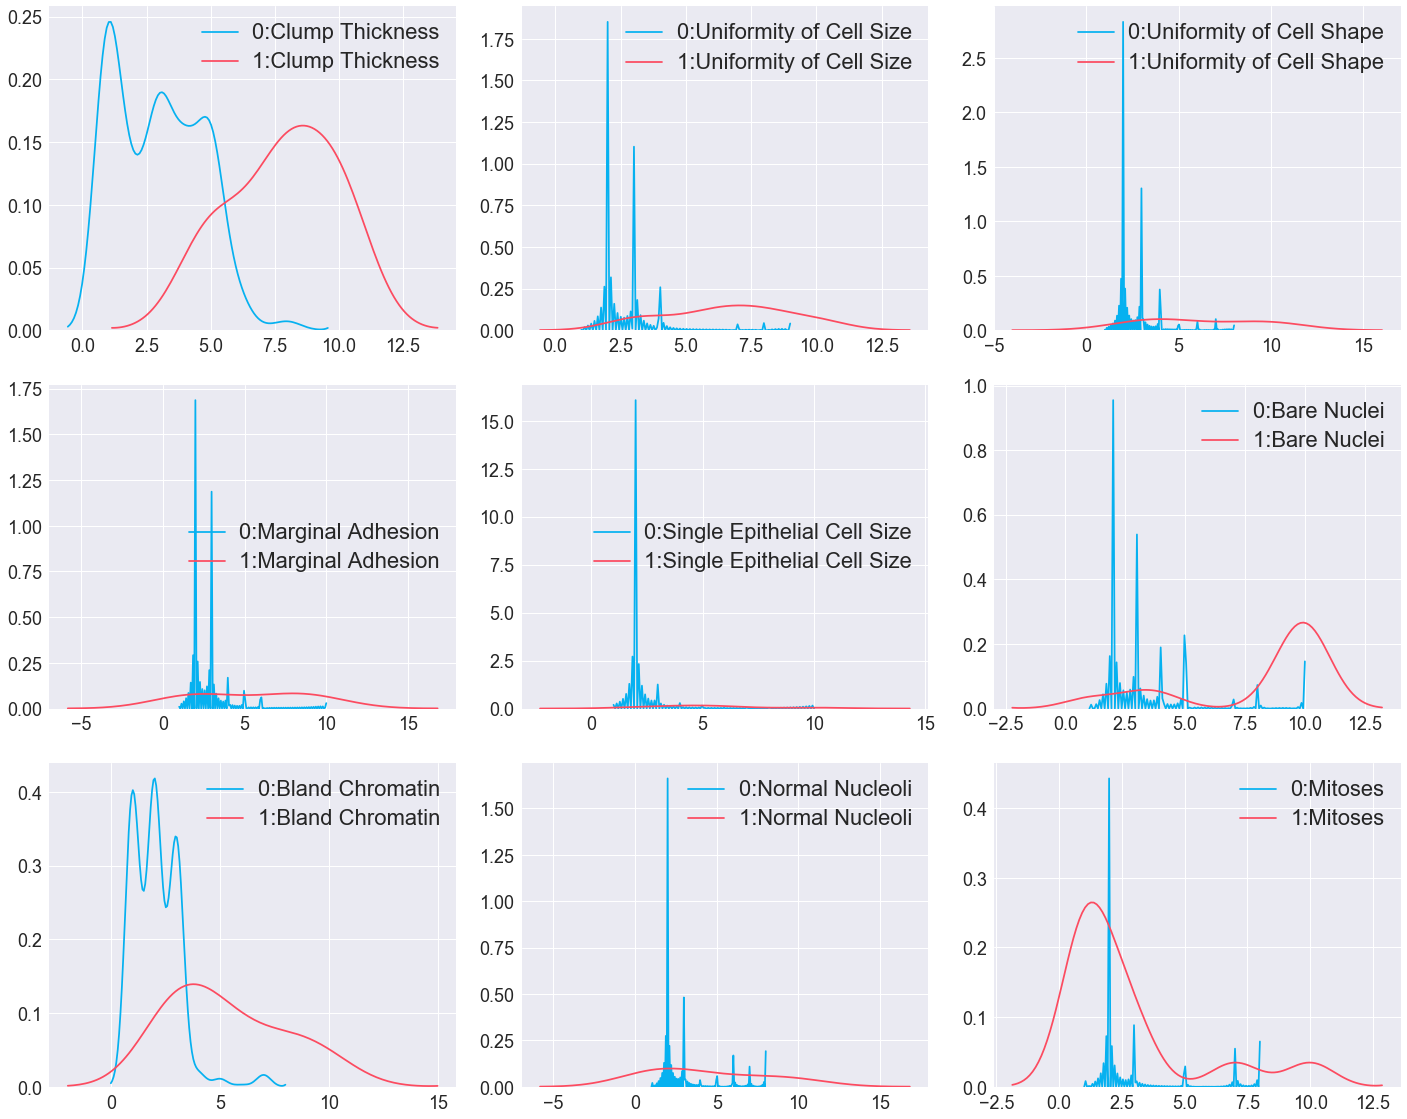

In [13]:
ccols = new_data.columns

grouped_data = new_data.groupby('Class')
sns.set(font_scale=1.8)
sns.set_palette(['#06B1F0', '#FC4B60'])
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 16), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), ccols):
    for k, v in grouped_data[p]:
        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name)
        plt.setp(ax.get_legend().get_texts(), fontsize='22')
plt.savefig('feature_distributions.png')

In the kernel density plots I am looking for variables with very little overlap between the malignant and benign tumor. Out of nine features, only two features have high discriminatory power between class 0 and 1

so the features did not contribute to model overfitting. It could be that there is something wrong with the way the oversampling and cross-validation were performed

Looks like there was information bleed from the validation set to the training set. 
The cross-validation was performed after upsampling, but the ideal way would be to perform oversampling of the training data in each cross-validation iteration. This would have prevented the data leakage from the validation set to the training set during cross-validation. 

## Oversampling in each cross-validation loop

In [14]:
kf = StratifiedKFold(n_splits=5, random_state=42)
cross_val_f1_score_lst = []
cross_val_accuracy_lst = []
cross_val_recall_lst = []
cross_val_precision_lst = []

for train_index, test_index in kf.split(x_train, y_train):
    # keeping validation set apart and oversampling in each iteration using smote 
    train, test = x_train.iloc[train_index], x_train.iloc[test_index]
    target_train, target_test = y_train[train_index], y_train[test_index]
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_sample(train, target_train.ravel())
    print X_train_res.shape, y_train_res.shape
    # training the model on oversampled 4 folds of training set
    rf = RandomForestClassifier(n_estimators=5, random_state=12)
    rf.fit(train, target_train)
    # testing on 1 fold of validation set
    test_preds = rf.predict(test)
    cross_val_recall_lst.append(recall_score(target_test, test_preds))
    cross_val_accuracy_lst.append(accuracy_score(target_test, test_preds))
    cross_val_precision_lst.append(precision_score(target_test, test_preds))
    cross_val_f1_score_lst.append(f1_score(target_test, test_preds))
print 'Cross validated accuracy: {}'.format(np.mean(cross_val_accuracy_lst))
print 'Cross validated recall score: {}'.format(np.mean(cross_val_recall_lst))
print 'Cross validated precision score: {}'.format(np.mean(cross_val_precision_lst))
print 'Cross validated f1_score: {}'.format(np.mean(cross_val_f1_score_lst))

(496, 9) (496,)
(498, 9) (498,)
(498, 9) (498,)
(498, 9) (498,)
(498, 9) (498,)
Cross validated accuracy: 0.984323870574
Cross validated recall score: 0.4
Cross validated precision score: 0.533333333333
Cross validated f1_score: 0.426666666667


### By doing over-sampling under each cross-validation loop, the cross-validated scores are representative of test set scores above 

In [15]:
r_s, p_s = np.mean(recall_scores), np.mean(precision_scores)
a_s, f_s = np.mean(accuracy_scores), np.mean(f1_scores)
r_s_1, p_s_1 = np.mean(cross_val_recall_lst), np.mean(cross_val_precision_lst)
a_s_1, f_s_1 = np.mean(cross_val_precision_lst), np.mean(cross_val_f1_score_lst)
metrics_df_wrong = pd.DataFrame(list(zip([r_s], [p_s], [f_s], [a_s])), columns=['Recall', 'Precision', 'F1-score', 'Accuracy'])
metrics_df_right = pd.DataFrame(list(zip([r_s_1], [p_s_1], [f_s_1], [a_s_1])), columns=['Recall', 'Precision', 'F1-score', 'Accuracy'])
metrics_df = pd.concat([metrics_df_wrong, metrics_df_right], axis=0)

In [16]:
metrics_df.index = (['Cross validation and oversampling done wrong', 'Cross validation and oversampling done right'])
metrics_df = metrics_df.transpose()

([<matplotlib.axis.XTick at 0x201c37b990>,
 <a list of 4 Text xticklabel objects>)

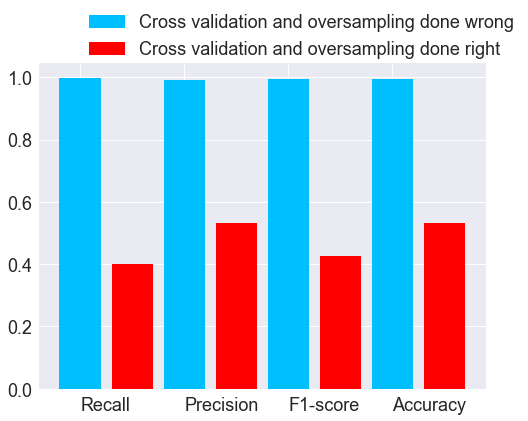

In [17]:
plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.bar([0,2,4,6], metrics_df['Cross validation and oversampling done wrong'], color='deepskyblue', label='Cross validation and oversampling done wrong')
ax.bar([1,3,5,7], metrics_df['Cross validation and oversampling done right'], color = 'red', label = 'Cross validation and oversampling done right')
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.2))
plt.xticks([0,2,4,6], ['Recall', 'Precision', 'F1-score', 'Accuracy'], horizontalalignment='left')

As we can see from the plot above, more representative results for test set were obtained when cross-validation and oversampling was done right. And also, oversampling correctly is no better than the baseline model for this dataset